# [실습] BERT Finetuning 하기

### 실습 목차
* 1. BERT Finetuning
  * 1-1. Single Sentence Classification Task
  * 1-2. Single Sentence Tagging Task
  * 1-3. Question Answering Task


In [22]:
# 라이브러리 import
import wget
import torch
import random
import numpy as np
import pandas as pd
import pytorch_lightning as pl

from tqdm import tqdm
from datasets import load_dataset
from transformers import BertTokenizer
from sklearn.metrics import matthews_corrcoef
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, random_split
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, BertForSequenceClassification, BertForTokenClassification, AdamW, BertConfig, AutoConfig, AutoModelForQuestionAnswering

## 1. BERT Finetuning 하기
BERT는 자연어 처리의 많은 문제를 해결하는 데 사용될 수 있습니다. 그 중 이번 실습에서는 사전학습 된 BERT를 finetuning 하여 대표적인 자연어 처리 문제(Single Sentence Classification, Single Sentence Tagging, Question Answering)들을 풀어보겠습니다.

이번 실습에서는 각 NLP task를 수행하는 특정 classifier layer가 결합된 사전 학습된 BERT 모델을 불러와 사용합니다.

### 1-1. Single Sentence Classification Task

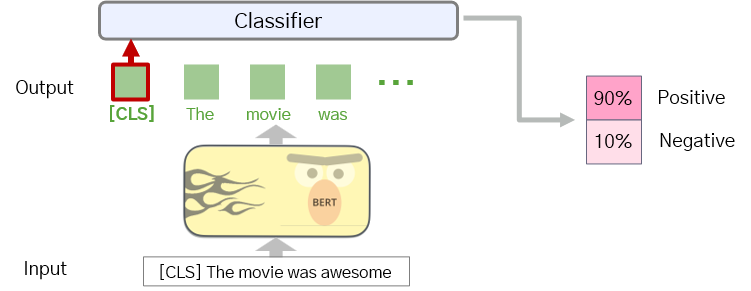


모델에 입력되는 단일 문장의 종류를 분류하는 문제입니다.

- Task에 대해 모델을 평가하기 위한 데이터셋으로 CoLA (The Corpus of Linguisic Acceptability)를 사용합니다. CoLA는 문장마다 문법적으로 올바르거나 잘못된 것으로 레이블이 지정된 데이터입니다.

- 평가지표는 Matthews correlation을 사용합니다.

#### 학습 데이터 준비

In [23]:
# CoLA 데이터셋 다운로드
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
wget.download(url, './cola_public_1.1.zip')

'./cola_public_1.1.zip'

In [24]:
!unzip ./dataset/single_sentence_classification/cola_public_1.1.zip -C ./dataset/single_sentence_classification/

Archive:  ./dataset/single_sentence_classification/cola_public_1.1.zip
caution: filename not matched:  -C
caution: filename not matched:  ./dataset/single_sentence_classification/


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
df_train = pd.read_csv("./dataset/single_sentence_classification/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_train = df_train.loc[:, ['sentence', 'label']]
df_train

,sentence,label
0,"Our friends won't buy this analysis, let alone...",1
1,One more pseudo generalization and I'm giving up.,1
2,One more pseudo generalization or I'm giving up.,1
3,"The more we study verbs, the crazier they get.",1
4,Day by day the facts are getting murkier.,1
...,...,...
8546,Poseidon appears to own a dragon,0
8547,Digitize is my happiest memory,0
8548,It is easy to slay the Gorgon.,1
8549,I had the strangest feeling that I knew you.,1


#### 데이터 토큰화

In [26]:
def load_tokenizer_and_model_for_train(args_train):
    """학습(train)을 위한 사전학습(pretrained) 토크나이저와 모델을 huggingface에서 load"""
    MODEL_NAME = args_train.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) ## 문장 분류를 위한 sequence classification, label의 수 설정.
    print("--- Modeling Done ---")
    
    return tokenizer , model

- `BertForSequenceClassification`: 입력으로 받은 문장이 어떤 종류의 문장인지 분류하는 classifier layer가 마지막 layer로 구성됩니다. Classifier layer는 [CLS] 토큰의 최종 임베딩 값을 통해서 입력 문장을 분류합니다.

In [27]:
def tokenized_dataset(dataset, tokenizer):
    print()
    print("tokenizer 에 들어가는 데이터 형태")
    print(list(dataset["sentence"])[-1])
    tokenized_senetences = tokenizer(list(dataset["sentence"]),
                                     add_special_tokens = True, # [CLS], [SEP] 토큰 추가
                                     max_length = 64,           # 패딩/잘라내기를 위한 최대 문장 길이
                                     pad_to_max_length = True,
                                     return_attention_mask = True,   # attention masks 출력
                                     return_tensors = 'pt')
    
    print("tokenizing 된 데이터 형태")
    print(tokenizer.convert_ids_to_tokens(tokenized_senetences['input_ids'][-1]))
    print(tokenized_senetences['input_ids'][-1])
    print()
    
    return tokenized_senetences

In [28]:
class ClsDataset(torch.utils.data.Dataset):
    """dataframe을 torch dataset class로 변환"""
    def __init__(self, news_dataset, labels):
        self.dataset = news_dataset
        self.labels = labels

    def __getitem__(self,idx):
        item = {
            key: val[idx].clone().detach() for key, val in self.dataset.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#### 학습 및 검증 데이터 분할
학습에 90%, 검증에 10%를 사용하도록 학습 세트를 나눕니다.

In [29]:
def prepare_dataset(dataset, tokenizer):
    """학습(train), 평가(test)를 위한 데이터셋을 준비"""
    # split train / test = 9 : 1
    train_dataset, valid_dataset = train_test_split(dataset, test_size=0.1, random_state=42)
    
    # input_ids, token_type_ids, attention_mask 생성
    tokenized_train = tokenized_dataset(train_dataset, tokenizer)
    tokenized_valid = tokenized_dataset(valid_dataset, tokenizer)

    # split label
    train_label = train_dataset['label'].values
    valid_label = valid_dataset['label'].values
    print("--- tokenizing Done ---")

    # make dataset for pytorch.
    cls_train_dataset = ClsDataset(tokenized_train, train_label)
    cls_valid_dataset = ClsDataset(tokenized_valid, valid_label)
    print("--- dataset class Done ---")

    return cls_train_dataset, cls_valid_dataset

#### 모델 학습

In [30]:
def load_trainer_for_train(model, train_dataset, test_dataset, tokenizer):
    """학습(train)을 위한 huggingface trainer 설정"""
    training_args = TrainingArguments(output_dir='./', per_device_train_batch_size=16, num_train_epochs=1)
    print("--- Set training arguments Done ---")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )
    print("--- Set Trainer Done ---")

    return trainer

In [31]:
def train(dataset, args_train):
    """모델을 학습(train)하고 best model을 저장"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # set model and tokenizer
    tokenizer, model = load_tokenizer_and_model_for_train(args_train)
    model.to(device)
    print("Classifier 확인: ", model.classifier )

    # set data
    cls_train_dataset, cls_valid_dataset = prepare_dataset(dataset, tokenizer)

    # set trainer
    trainer = load_trainer_for_train(model, cls_train_dataset, cls_valid_dataset, tokenizer)

    # train model
    print("--- Start train ---")
    trainer.train()
    print("--- Finish train ---")
    # # model.save_pretrained("./best_model")

In [32]:
class args_train():
    """학습(train)에 사용되는 arguments 관리하는 class"""
    model_name = "bert-base-uncased"

train(df_train[:10], args_train)

## Classifier 확인:  Linear(in_features=768, out_features=2, bias=True) -> 마지막 encoder hidden_state가 linear로 입력되서 2개 클래스에 대한 확률을 출력.
## tokenizing된 데이터 형태 : CLS 토큰이 맨 앞에 추가되고 문장을 구분하는 SEP, 최대 길이로 통일시키기 위한 PAD

Seed set to 42


device: cuda:0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/pervinco/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max le

--- Modeling Done ---
Classifier 확인:  Linear(in_features=768, out_features=2, bias=True)

tokenizer 에 들어가는 데이터 형태
Fred watered the plants flat.
tokenizing 된 데이터 형태
['[CLS]', 'fred', 'watered', 'the', 'plants', 'flat', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
tensor([  101,  5965, 27129,  1996,  4264,  4257,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  

Step,Training Loss


--- Finish train ---


Single Sentence Classification Task를 수행하기 위해 classifier는 2가지 문장 종류를 분류하게 됩니다. 예측 값을 가지고 loss를 구하여 모델 학습이 진행됩니다.

#### 모델 테스트
모델의 테스트를 수행하기 위해 테스트 데이터를 준비합니다. 아래의 과정은 학습 데이터를 구성하는 과정과 같습니다.

In [33]:
df_test = pd.read_csv("./dataset/single_sentence_classification/cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_test.head()

,sentence_source,label,label_notes,sentence
0,clc95,1,NaN,Somebody just left - guess who.
1,clc95,1,NaN,"They claimed they had settled on something, bu..."
2,clc95,1,NaN,"If Sam was going, Sally would know where."
3,clc95,1,NaN,"They're going to serve the guests something, b..."
4,clc95,1,NaN,She's reading. I can't imagine what.


In [34]:
def load_model_for_inference(args_test):
    """추론(infer)에 필요한 모델과 토크나이저 load """
    MODEL_NAME = args_test.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = BertForSequenceClassification.from_pretrained(MODEL_NAME,
                                                          num_labels=2)
    print("--- Modeling Done ---")
    return tokenizer, model

In [35]:
def inference(args_test, model, tokenized_sent, device):
    """학습된(trained) 모델을 통해 결과를 추론하는 function"""
    dataloader = DataLoader(tokenized_sent, batch_size=args_test.batch_size, shuffle=False)
    model.eval()
    output_pred = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
                input_ids=data["input_ids"].to(device),
                attention_mask=data["attention_mask"].to(device),
            )
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        result = np.argmax(logits, axis=-1)

        output_pred.append(result)
    return (np.concatenate(output_pred).tolist(),)

In [36]:
def infer_and_eval(test_dataset, args_test):
    """학습된 모델로 추론(infer)한 후에 예측한 결과(pred)를 평가(eval)"""
    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # set model & tokenizer
    tokenizer, model = load_model_for_inference(args_test)
    model.to(device)

    # set data
    tokenized_test = tokenized_dataset(test_dataset, tokenizer)
    test_label = test_dataset['label'].values
    cls_test_dataset = ClsDataset(tokenized_test, test_label)

    # predict answer
    pred_answer = inference(args_test, model, cls_test_dataset, device)  # model에서 class 추론
    print("--- Prediction done ---")

    print("test_label: ", list(test_label[:30]))
    print("pred_answer: ", pred_answer[0][:30])
    # return model, cls_test_dataset, device

    mcc = matthews_corrcoef(test_label, pred_answer[0])
    print("\n ----- Total MCC: %.3f -----" % mcc)


CoLA 벤치마크의 정확도는 "MCC(Mathews Correlation Coefficient)"를 사용하여 측정합니다.

In [37]:
class args_test():
    """학습(train)에 사용되는 arguments 관리하는 class"""
    model_name = "Ruizhou/bert-base-uncased-finetuned-cola"
    batch_size = 64

infer_and_eval(df_test, args_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/pervinco/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


--- Modeling Done ---

tokenizer 에 들어가는 데이터 형태
John talked to Bill about himself.
tokenizing 된 데이터 형태
['[CLS]', 'john', 'talked', 'to', 'bill', 'about', 'himself', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
tensor([ 101, 2198, 5720, 2000, 3021, 2055, 2370, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

100%|██████████| 9/9 [00:00<00:00, 46.18it/s]


--- Prediction done ---
test_label:  [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
pred_answer:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 ----- Total MCC: 0.551 -----


### 1-2. Single Sentence Tagging Task

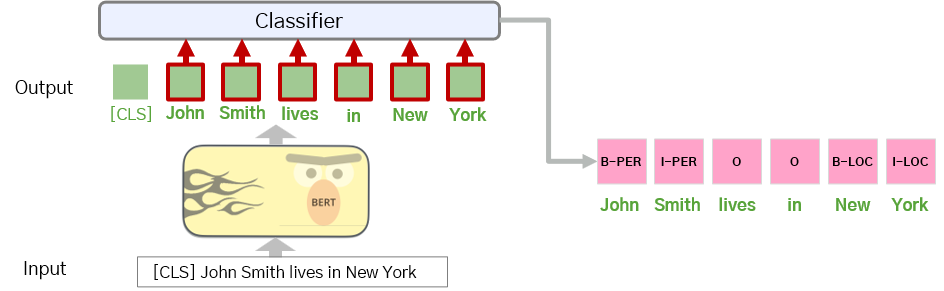


입력 문장 토큰들의 개체명을 구하거나 품사를 구하는 문제입니다.

Task에 대해 모델을 평가하기 위한 데이터셋으로 CoNLL-2003 NER(Named Entity Recognition)를 사용합니다.

- CoNLL-2003 NER는 문장의 각 토큰을 인물(PER), 기관 및 단체(ORG), 장소 및 위치(LOC) 중 하나의 개체명으로 묶어주는 태깅 작업을 위한 데이터셋입니다.

#### 학습 데이터 준비

In [38]:
dataset = load_dataset("conll2003")

#### 데이터 토큰화

In [39]:
def tokenize_adjust_labels(dataset, tokenizaed_data, label_names):
    ## NER(개체명 인식)은 토큰나이저에 따라서 label이 달라지게 된다.
    ## 예를 들어 john smith라는 하나의 이름이 단순히 띄어쓰기로 토큰화될지, jo, hn와 같이 토큰화될지에 따라 label부여가 달라져야함.
    ## label_names: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

    total_adjusted_labels = []
    for k in range(0, len(tokenizaed_data["input_ids"])):
        prev_wid = -1

        ## word_ids는 하나의 단어가 토크나이징 되었을 때 어디부터 어디까지가 하나의 단어인가를 고려하여 토큰화한 결과를 보여준다.
        word_ids_list = tokenizaed_data.word_ids(batch_index=k) # [None, 0, 0, 0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, None]
        
        ## 기존에 단어 단위로 있었던 label
        existing_label_ids = dataset["ner_tags"][k] # [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0]
        i = -1

        adjusted_label_ids = []
        for wid in word_ids_list:
        # special 토큰에는 -100으로 레이블을 부여
            if(wid is None):
                adjusted_label_ids.append(-100)
            elif(wid!=prev_wid):
                i = i + 1
                adjusted_label_ids.append(existing_label_ids[i])
                prev_wid = wid
            else:

                label_name = label_names[existing_label_ids[i]]
                adjusted_label_ids.append(existing_label_ids[i])

        total_adjusted_labels.append(adjusted_label_ids) # [-100, 3, 3, 3, 3, 4, 0, 3, 3, 4, 4, 0, 0, 0, 0, 0, 0, -100]
    tokenizaed_data["labels"] = total_adjusted_labels

    print("토큰화 후 word ids: ", word_ids_list)
    print("토큰화 전 label_ids: ", existing_label_ids)
    print("토큰화 후 label_ids: ", adjusted_label_ids)
    print()
    return tokenizaed_data

In [40]:
def load_tokenizer_and_model_for_train(label_names):
    """학습(train)을 위한 사전학습(pretrained) 토크나이저와 모델을 huggingface에서 load"""
    MODEL_NAME = args_train.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                       num_labels=len(label_names))
    print("--- Modeling Done ---")
    return tokenizer , model

In [41]:
def tokenized_dataset(dataset, tokenizer):
    print()
    print("tokenizer 에 들어가는 데이터 형태")
    print(dataset["tokens"][-1])
    tokenized_senetences = tokenizer(dataset["tokens"], is_split_into_words=True)
    print("tokenizing 된 데이터 형태")
    print(tokenized_senetences['input_ids'][-1])
    print()
    return tokenized_senetences

In [42]:
class TagDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

#### 학습 및 검증 데이터 분할

In [43]:
def prepare_dataset(dataset, tokenizer, label_names):
    """학습(train), 검증(valid), 평가(test)를 위한 데이터셋을 준비"""
    # input_ids, token_type_ids, attention_mask 생성
    tokenized_sentence = tokenized_dataset(dataset, tokenizer)
    print("--- tokenizing Done ---")

    # 토큰화된 형식에 레이블 맞추기
    tokenized_sentence = tokenize_adjust_labels(dataset, tokenized_sentence, label_names)

    # make dataset for pytorch.
    tag_dataset = TagDataset(tokenized_sentence)
    print("--- dataset class Done ---")

    return tag_dataset

#### 모델 학습

In [44]:
def load_trainer_for_train(model, train_dataset, tokenizer):
    """학습(train)을 위한 huggingface trainer 설정"""
    training_args = TrainingArguments(
        output_dir='./',
        per_device_train_batch_size=16,
        num_train_epochs=10
    )
    print("--- Set training arguments Done ---")

    data_collator = DataCollatorForTokenClassification(tokenizer)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        data_collator=data_collator,
    )
    print("--- Set Trainer Done ---")

    return trainer

In [45]:
def train(train_dataset):
    """모델을 학습(train)하고 best model을 저장"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # set model and tokenizer
    label_names = train_dataset.features["ner_tags"].feature.names
    tokenizer, model = load_tokenizer_and_model_for_train(label_names)
    model.to(device)
    print("Classifier 확인: ", model.classifier )

    # set data
    tag_train_dataset = prepare_dataset(train_dataset[:1], tokenizer, label_names)

    # set trainer
    trainer = load_trainer_for_train(model, tag_train_dataset, tokenizer)

    # train model
    print("--- Start train ---")
    trainer.train()
    print("--- Finish train ---")
    # # model.save_pretrained("./best_model")

In [46]:
class args_train():
    """학습(train)에 사용되는 arguments 관리하는 class"""
    model_name = "bert-base-uncased"

train(dataset['train'])

Seed set to 42


device: cuda:0


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Modeling Done ---
Classifier 확인:  Linear(in_features=768, out_features=9, bias=True)

tokenizer 에 들어가는 데이터 형태
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
tokenizing 된 데이터 형태
[101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102]

--- tokenizing Done ---
토큰화 후 word ids:  [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]
토큰화 전 label_ids:  [3, 0, 7, 0, 0, 0, 7, 0, 0]
토큰화 후 label_ids:  [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]

--- dataset class Done ---
--- Set training arguments Done ---
--- Set Trainer Done ---
--- Start train ---


Step,Training Loss


--- Finish train ---


#### 모델 Inference 과정

In [47]:
def load_model_for_inference(label_names):
    """추론(infer)에 필요한 모델과 토크나이저 load """
    MODEL_NAME = args_test.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = BertForTokenClassification.from_pretrained(MODEL_NAME,
                                                       num_labels=len(label_names))
    print("--- Modeling Done ---")
    return tokenizer, model

In [48]:
def tokenized_test_dataset(dataset, tokenizer):
    print()
    print("tokenizer 에 들어가는 데이터 형태")
    print(dataset["tokens"][-1])
    tokenized_senetences = tokenizer(dataset["tokens"],
                                     is_split_into_words=True,
                                     return_tensors="pt")
    print("tokenizing 된 데이터 형태")
    print(tokenized_senetences['input_ids'][-1])
    print()
    return tokenized_senetences

In [49]:
def infer_and_eval(test_dataset):
    """학습된 모델로 추론(infer)한 후에 예측한 결과(pred)를 평가(eval)"""
    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # set model & tokenizer
    label_names = test_dataset.features["ner_tags"].feature.names
    tokenizer, model = load_model_for_inference(label_names)
    model.to(device)

    # set data
    tokenized_test = tokenized_test_dataset(test_dataset[10:11], tokenizer)
    tokenized_test = tokenize_adjust_labels(test_dataset[10:11], tokenized_test, label_names)

    return tokenizer, model, tokenized_test, label_names, device

In [50]:
class args_test():
    """학습(train)에 사용되는 arguments 관리하는 class"""
    model_name = "andi611/bert-base-cased-ner-conll2003"
    batch_size = 32

tag_tokenizer, tag_model, tag_tokenized_test, label_names, device = infer_and_eval(dataset['test'])

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

--- Modeling Done ---

tokenizer 에 들어가는 데이터 형태
['Takuya', 'Takagi', 'scored', 'the', 'winner', 'in', 'the', '88th', 'minute', ',', 'rising', 'to', 'head', 'a', 'Hiroshige', 'Yanagimoto', 'cross', 'towards', 'the', 'Syrian', 'goal', 'which', 'goalkeeper', 'Salem', 'Bitar', 'appeared', 'to', 'have', 'covered', 'but', 'then', 'allowed', 'to', 'slip', 'into', 'the', 'net', '.']
tokenizing 된 데이터 형태
tensor([  101, 22515,  4786,  2315, 22515,  1968,  5389,  2297,  1103,  2981,
         1107,  1103,  5385,  1582,  2517,   117,  4703,  1106,  1246,   170,
         8790,  5864,  3031,  2176, 14932, 27547, 12610,  2771,  2019,  1103,
         8697,  2273,  1134, 10159, 10293, 27400,  1813,  1691,  1106,  1138,
         2262,  1133,  1173,  2148,  1106,  7324,  1154,  1103,  5795,   119,
          102])

토큰화 후 word ids:  [None, 0, 0, 0, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 14, 14, 14, 14, 15, 15, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,

In [51]:
ids_to_labels = {v: k for v, k in enumerate(label_names)}
ids_to_labels

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [52]:
print("테스트 문장 토큰 : NER 정답 레이블")
for token, tag_id in zip(dataset['test'][10:11]['tokens'][0], dataset['test'][10:11]['ner_tags'][0]):
    print('%15s' % token, ":", tag_id)

테스트 문장 토큰 : NER 정답 레이블
         Takuya : 1
         Takagi : 2
         scored : 0
            the : 0
         winner : 0
             in : 0
            the : 0
           88th : 0
         minute : 0
              , : 0
         rising : 0
             to : 0
           head : 0
              a : 0
      Hiroshige : 1
     Yanagimoto : 2
          cross : 0
        towards : 0
            the : 0
         Syrian : 7
           goal : 0
          which : 0
     goalkeeper : 0
          Salem : 1
          Bitar : 2
       appeared : 0
             to : 0
           have : 0
        covered : 0
            but : 0
           then : 0
        allowed : 0
             to : 0
           slip : 0
           into : 0
            the : 0
            net : 0
              . : 0


In [53]:
# 모델에 토큰화된 문장 입력하여 tag 예측
tag_outputs = tag_model(input_ids=tag_tokenized_test["input_ids"].to(device),
                        attention_mask=tag_tokenized_test["attention_mask"].to(device))
logits = tag_outputs[0]
logits = logits.detach().cpu().numpy()

In [54]:
predictions = []
for i in range(logits[0].shape[0]):
    logits_clean = logits[0][i][tag_tokenized_test['labels'][0][i] != -100]
    prediction = logits_clean.argmax(axis=1)
    predictions += list(prediction)

In [55]:
tokens = tag_tokenizer.convert_ids_to_tokens(tag_tokenized_test['input_ids'].squeeze().tolist())
token_tag_predictions = [ids_to_labels[i] for i in predictions]
print("tokens:", tokens)
print("token_tag_predictions:", token_tag_predictions)

tokens: ['[CLS]', 'Ta', '##ku', '##ya', 'Ta', '##ka', '##gi', 'scored', 'the', 'winner', 'in', 'the', '88', '##th', 'minute', ',', 'rising', 'to', 'head', 'a', 'Hi', '##ros', '##hi', '##ge', 'Yan', '##agi', '##moto', 'cross', 'towards', 'the', 'Syrian', 'goal', 'which', 'goalkeeper', 'Salem', 'Bit', '##ar', 'appeared', 'to', 'have', 'covered', 'but', 'then', 'allowed', 'to', 'slip', 'into', 'the', 'net', '.', '[SEP]']
token_tag_predictions: ['B-PER', 'B-PER', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'B-PER', 'B-PER', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [56]:
# 단어 단위로 tag 예측 결과를 조절
word_level_predictions = []
for pair in list(zip(tokens, token_tag_predictions)):
    if (pair[0].startswith("##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
        continue
    else:
        word_level_predictions.append(pair[1])

In [57]:
print("테스트 문장 토큰 : NER 예측 레이블")
for word, tag in zip(dataset['test'][10:11]['tokens'][0], word_level_predictions):
    print('%15s' % word, ":", tag)

테스트 문장 토큰 : NER 예측 레이블
         Takuya : B-PER
         Takagi : I-PER
         scored : O
            the : O
         winner : O
             in : O
            the : O
           88th : O
         minute : O
              , : O
         rising : O
             to : O
           head : O
              a : B-PER
      Hiroshige : B-PER
     Yanagimoto : I-PER
          cross : O
        towards : O
            the : B-MISC
         Syrian : O
           goal : O
          which : O
     goalkeeper : B-PER
          Salem : I-PER
          Bitar : I-PER
       appeared : O
             to : O
           have : O
        covered : O
            but : O
           then : O
        allowed : O
             to : O
           slip : O
           into : O
            the : O
            net : O


### 1-3. Question Answering Task

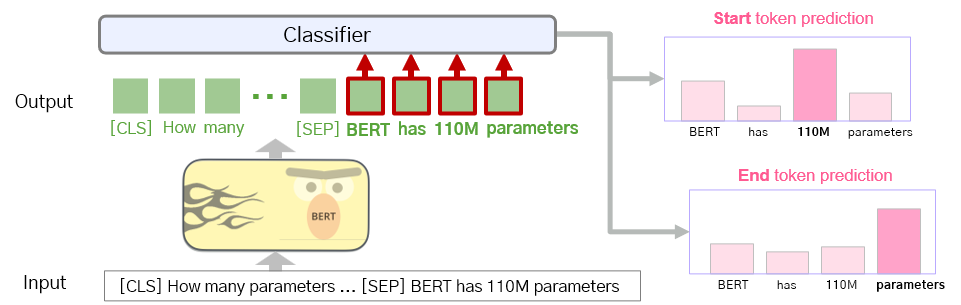


문단 내에서 원하는 정답 위치를 맞추는 문제입니다.

Task에 대해 모델을 평가하기 위한 데이터셋으로 SQuAD v1.1(Stanford Question Answering Dataset)를 사용합니다.

- SQuAD v1.1는 질의응답

#### 학습 데이터 준비

In [58]:
# 학습 및 평가 데이터셋 준비
train, test = load_dataset("squad", split =['train[0:10]', 'validation[0:10]']) # SQuAD 데이터셋 로드

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

추출형 질의 응답의 벤치마크로 가장 많이 사용되는 SQuAD v1.1 데이터셋을 사용하겠습니다. SQuAD는 일련의 Wikipedia 기사에서 크라우드 워커가 제기 한 질문으로 구성된 독해 이해 데이터 세트입니다.

In [59]:
df_train = train.to_pandas().loc[:, ['context', 'question', 'answers']]
df_test = test.to_pandas().loc[:, ['context', 'question', 'answers']]

In [60]:
# 문단 데이터
df_train['context'][0]

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

In [61]:
# 질문 데이터
df_train['question'][0]

'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [62]:
# 정답 문자열과 시작 위치
df_train['answers'][0]

{'text': array(['Saint Bernadette Soubirous'], dtype=object),
 'answer_start': array([515], dtype=int32)}

In [63]:
# 정답 문자열의 시작과 끝 레이블링
def find_start_end_position(answers, texts):
    for answer, text in zip(answers, texts):
        real_answer = answer['text'][0]
        start_idx = answer['answer_start'][0]
        end_idx = start_idx + len(real_answer)
        answer['answer_end'] = end_idx

    return answers

QA task를 수행하기 위해선 본문에서 정답이 시작하고 끝나는 위치를 알아야 합니다. 따라서, 추가로 끝나는 위치까지 데이터에 넣어줍니다.

In [64]:
# 정답 문자열 index 찾기
df_train['answers'] = find_start_end_position(df_train['answers'], df_train['context'])
df_test['answers'] = find_start_end_position(df_test['answers'], df_test['context'])

In [65]:
df_train['answers'][0]

{'text': array(['Saint Bernadette Soubirous'], dtype=object),
 'answer_start': array([515], dtype=int32),
 'answer_end': 541}

#### 데이터 토큰화

In [66]:
def load_tokenizer_and_model_for_train():
    """학습(train)을 위한 사전학습(pretrained) 토크나이저와 모델을 huggingface에서 load"""
    MODEL_NAME = args_train.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    print("--- Modeling Done ---")
    return tokenizer , model

In [67]:
def tokenized_dataset(dataset, tokenizer):
    """[[CLS] context [SEP] question [SEP]]형태로 토크나이징"""
    tokenized_senetences = tokenizer(
        list(dataset['context']),
        list(dataset['question']),
        padding = True,
        truncation = True
    )
    print("--- tokenizing Done ---")
    return tokenized_senetences

In [68]:
def add_token_positions(tokenizer, encodings, answers):
    start_positions = []
    end_positions = []

    count = 0
    for i in range(len(answers)):
        # 토큰화된 context에서 첫번째 정답 토큰의 index를 가져옵니다.
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start'][0]))
        # 토큰화된 context에서 마지막 정답 토큰의 index를 가져옵니다.
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # 최대 길이를 넘어 정답 토큰을 토큰화된 context에서 찾지 못 했을 때
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
        if end_positions[-1] is None:
            count += 1
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [69]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

#### 학습 및 검증 데이터 분할

In [70]:
def prepare_dataset(train_dataset, test_dataset, tokenizer):
    """학습(train)과 평가(test)를 위한 데이터셋을 준비"""

    print("tokenizer 에 들어가는 데이터 형태")
    print('[CLS]' + train_dataset['context'][0] + '[SEP]' + train_dataset['question'][0] + '[SEP]')
    tokenized_train = tokenized_dataset(train_dataset, tokenizer)
    tokenized_test = tokenized_dataset(test_dataset, tokenizer)
    print("tokenizing 된 데이터 형태")
    print(tokenized_train['input_ids'][:1])

    add_token_positions(tokenizer, tokenized_train, train_dataset['answers'])
    add_token_positions(tokenizer, tokenized_test, test_dataset['answers'])
    print("정답 토큰 정보: ", train_dataset['answers'][0])
    print("정답 시작 토큰: ", tokenized_train['start_positions'][0])
    print("정답 마지막 토큰: ", tokenized_train['end_positions'][0])

    qa_train_dataset = SquadDataset(tokenized_train)
    qa_test_dataset = SquadDataset(tokenized_test)
    print("--- dataset class Done ---")

    return qa_train_dataset, qa_test_dataset

#### 모델 학습

In [71]:
def load_trainer_for_train(model, train_dataset):
    """학습(train)을 위한 huggingface trainer 설정"""
    training_args = TrainingArguments(
        output_dir='./',
        per_device_train_batch_size=32,
        num_train_epochs=1
    )
    print("--- Set training arguments Done ---")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )
    print("--- Set Trainer Done ---")

    return trainer

In [72]:
def train(train_dataset, test_dataset):
    """모델을 학습(train)하고 best model을 저장"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # set model and tokenizer
    tokenizer , model = load_tokenizer_and_model_for_train()
    model.to(device)

    # set data
    qa_train_dataset, qa_test_dataset = prepare_dataset(train_dataset, test_dataset, tokenizer)

    # set trainer
    trainer = load_trainer_for_train(model, qa_train_dataset)

    # train model
    print("--- Start train ---")
    trainer.train()
    print("--- Finish train ---")
    model.save_pretrained("./best_model")

In [73]:
class args_train():
    """학습(train)에 사용되는 arguments 관리하는 class"""
    model_name = "bert-base-uncased"

train(df_train, df_test)

Seed set to 42


device: cuda:0


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Modeling Done ---
tokenizer 에 들어가는 데이터 형태
[CLS]Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.[SEP]To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?[SEP]
--- tokenizing Done ---
--- tokenizing Done ---
tokenizing 된 데이터 형태
[[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 

Step,Training Loss


--- Finish train ---


#### 모델 Inference 과정

In [74]:
def load_model_for_inference():
    """추론(infer)에 필요한 모델과 토크나이저 load """
    MODEL_NAME = args_test.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    print("--- Modeling Done ---")
    return tokenizer, model

In [75]:
def inference(model, tokenized_sent, tokenizer, device):
    """학습된(trained) 모델을 통해 결과를 추론하는 function"""
    dataloader = DataLoader(tokenized_sent, batch_size=args_test.batch_size, shuffle=False)
    model.eval()
    output_pred = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
                input_ids=data["input_ids"].to(device),
                attention_mask=data["attention_mask"].to(device))

        # 시작과 끝 문자열 출력
        start_pred = outputs.start_logits.argmax(dim=-1)
        end_pred = outputs.end_logits.argmax(dim=-1)
        answer_ids = data['input_ids'][0][start_pred:end_pred+1]
        pred_text = tokenizer.decode(answer_ids)

        output_pred.append(pred_text)
    return (np.concatenate(output_pred).tolist(),)

In [76]:
def tokenized_test_dataset(dataset, tokenizer):
    """[[CLS] context [SEP] question [SEP]]형태로 토크나이징"""
    tokenized_senetences = tokenizer(
        list(dataset['context']),
        list(dataset['question']),
        padding = True,
        truncation = True,
        return_tensors="pt"
    )
    print("--- tokenizing Done ---")
    return tokenized_senetences

In [77]:
def infer_and_eval(test_dataset):
    """학습된 모델로 추론(infer)한 후에 예측한 결과(pred)를 평가(eval)"""
    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # set model & tokenizer
    tokenizer, model = load_model_for_inference()
    model.to(device)

    # set data
    tokenized_test = tokenized_test_dataset(test_dataset, tokenizer)

    return tokenizer, model, tokenized_test, device

test 데이터셋의 첫번째 데이터(`df_test[:1]`)를 모델에 입력하면 모델이 어떻게 추론을 하는지 알아보겠습니다.

In [78]:
class args_test():
    """학습(train)에 사용되는 arguments 관리하는 class"""
    model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
    batch_size = 32

qa_tokenizer, qa_model, qa_tokenized_test, device = infer_and_eval(df_test[:1])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


--- Modeling Done ---
--- tokenizing Done ---


In [79]:
print("테스트 문단: ")
df_test[:1]['context'][0]

테스트 문단: 


'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.'

In [80]:
print("테스트 질문 문장: ", df_test[:1]['question'][0])
print("테스트 정답 문자열: ", df_test[:1]['answers'][0]['text'])

테스트 질문 문장:  Which NFL team represented the AFC at Super Bowl 50?
테스트 정답 문자열:  ['Denver Broncos' 'Denver Broncos' 'Denver Broncos']


In [81]:
qa_outputs = qa_model(input_ids=qa_tokenized_test['input_ids'].to(device),
                      attention_mask=qa_tokenized_test['attention_mask'].to(device))

모델에 토크나이즈 된 결과들을 입력합니다.

In [82]:
# 추론된 시작과 끝 토큰의 위치
start_pred = qa_outputs.start_logits.argmax(dim=-1)
end_pred = qa_outputs.end_logits.argmax(dim=-1)

print("start_pred, end_pred: ", start_pred, end_pred)

start_pred, end_pred:  tensor([34], device='cuda:0') tensor([35], device='cuda:0')


In [83]:
# 최종적인 정답 문자열 출력
qa_token_ids = qa_tokenized_test['input_ids'][0][start_pred:end_pred+1]
pred_text = qa_tokenizer.decode(qa_token_ids)
print("pred_text: ", pred_text)

pred_text:  denver broncos
